# On Tourism Pressure: Analyzing Spatial Patterns Using Geospatial Techniques

In [2]:
from IPython.display import HTML

HTML('''
<script>
function code_toggle() {
    var code_cells = document.querySelectorAll('.code_cell');
    code_cells.forEach(function(cell) {
        cell.style.display = (cell.style.display === 'none' ? '' : 'none');
    });
}
</script>

<form action="javascript:code_toggle()">
    <input type="submit" value="Hide/Show Code">
</form>
''')

In [3]:
!pip install plotly

In [4]:
import geopandas as gpd
import pandas as pd 
import requests
from glob import glob
import matplotlib.pyplot as plt
from pyproj import Transformer
import plotly.express as px
import plotly.graph_objects as go
import osmnx as ox
from shapely import wkt
import libpysal as lps
from esda.moran import Moran
from shapely.geometry import Point
from sklearn.cluster import AgglomerativeClustering

from utils import make_isochrone_polys
import warnings

warnings.filterwarnings("ignore")

## Executive Summary

This report examines the spatial distribution of disposable household income per capita and the Gini index across Barcelona’s districts and neighbourhoods in 2022. Using data from the Barcelona Open Data portal, a spatial analysis is conducted to identify patterns of income variation across the city.

The analysis is subsequently contextualised using tourism-related indicators derived from Airbnb listings. The spatial distribution, density, and pricing of listings are analyzed in relation to accessibility to the city centre using walking isochrones. In addition, a regionalisation approach is applied to group neighbouring census areas into spatially coherent regions based on tourism-related and socio-economic data , allowing broader patterns of tourism pressure across the city to be identified.

The findings aim to contribute to ongoing discussions about urban inequality, tourism pressure, and the socio-economic impacts of tourism in Barcelona.

## 1 Introduction 

Tourism has been a persistent and increasingly polarizing issue in Spain over the past decade, particularly in one of the major tourist destinations like Barcelona. The rapid growth of tourism-related activities has generated economic benefits while simultaneously increasing tourism pressure on urban space, housing markets, and local services. Tourism pressure has raised concerns among residents regarding housing affordability<sup>[1](https://www.theguardian.com/world/2025/jan/20/a-vicious-circle-how-the-roof-blew-off-spains-housing-crisis)</sup>, income inequality, and the livability of the neighborhoods. In recent years, these tensions have manifested in public protests<sup>[2](https://www.idealista.com/en/news/lifestyle-in-spain/2025/09/29/861856-world-tourism-day-protests-in-barcelona-what-happened-and-why)</sup>.

Collectively, these developments suggest that tourism in Barcelona has evolved from a primarily economic opportunity into a more complex urban issue, shaping policy debates around housing regulation, urban sustainability, and social equity.

The goal of this study is to explore different datasets to understand spatial patterns in Barcelona and how they relate to tourism pressure.

## 2 Data 

In this section, we prepare and describe the datasets used for analysis.

### 2.1 Disposable Income

Estimation of the disposable income of households per person (€) in the city of Barcelona by census sections, based on the Income Account for Barcelona of Idescat and the Atlas de Distribución de la Renta de los Hogares of the INE<sup>[3](https://opendata-ajuntament.barcelona.cat/data/en/dataset/renda-disponible-llars-bcn)</sup>.

In [5]:
import json
import pandas as pd
import urllib.request

url = "https://opendata-ajuntament.barcelona.cat/data/api/3/action/datastore_search?resource_id=3df0c5b9-de69-4c94-b924-57540e52932f&limit=2000"

with urllib.request.urlopen(url) as f:
    data = json.loads(f.read().decode("utf-8"))

df_income = pd.DataFrame(data["result"]["records"])[['Codi_Districte', 'Seccio_Censal', 'Codi_Barri', 'Import_Euros']]
df_income.shape

(1068, 4)

In [6]:
df_income.head()

Codi_Districte Seccio_Censal Codi_Barri Import_Euros
0              1             1          1        15940
1              1             2          1        13841
2              1             3          1        12732
3              1             4          1        15749
4              1             5          1        13190

### 2.2 Gini index (%) of tax income in the city of Barcelona

Gini index (%) of tax income in the city of Barcelona by census sections, based on the Atlas de distribución de la renta de los hogares of the Instituto Nacional de Estadística (INE)<sup>[4](https://opendata-ajuntament.barcelona.cat/data/en/dataset/atles-renda-index-gini)</sup>.

In [7]:
import json
import pandas as pd
import urllib.request

url = "https://opendata-ajuntament.barcelona.cat/data/api/3/action/datastore_search?resource_id=dea9d3f3-a828-4a49-b582-089ba6c9b356&limit=2000"

with urllib.request.urlopen(url) as f:
    data = json.loads(f.read().decode("utf-8"))

df_gini = pd.DataFrame(data["result"]["records"])[['Codi_Districte', 'Seccio_Censal', 'Codi_Barri', 'Index_Gini']]
df_gini.shape


(1068, 4)

In [8]:
df_gini.head()

Codi_Districte Seccio_Censal Codi_Barri Index_Gini
0              1             1          1       35.6
1              1             2          1       34.8
2              1             3          1       36.1
3              1             4          1       35.6
4              1             5          1       35.7

In [9]:
df_soc = (
    df_income
    .assign(
        Codi_Districte=lambda x: x["Codi_Districte"].str.zfill(2),
        Seccio_Censal=lambda x: x["Seccio_Censal"].str.zfill(3),
        Codi_Barri=lambda x: x["Codi_Barri"].str.zfill(2),
    )
    .merge(
        df_gini.assign(
            Codi_Districte=lambda x: x["Codi_Districte"].str.zfill(2),
            Seccio_Censal=lambda x: x["Seccio_Censal"].str.zfill(3),
            Codi_Barri=lambda x: x["Codi_Barri"].str.zfill(2),
        ),
        on=["Codi_Districte", "Seccio_Censal", "Codi_Barri"],
        how="inner"
    )
)

df_soc.shape

(1068, 5)

In [10]:
df_soc.head()

Codi_Districte Seccio_Censal Codi_Barri Import_Euros Index_Gini
0             01           001         01        15940       35.6
1             01           002         01        13841       34.8
2             01           003         01        12732       36.1
3             01           004         01        15749       35.6
4             01           005         01        13190       35.7

### 2.3 Administrative Boundaries

Administrative units defining the census areas of the city of Barcelona, used as the spatial reference for census-section–level analysis<sup>[5](https://opendata-ajuntament.barcelona.cat/data/en/dataset/20170706-districtes-barris/resource/e16856a7-b3c0-4c32-a468-cc190cbbf7a9)</sup>.

In [11]:
url = "https://opendata-ajuntament.barcelona.cat/resources/bcn/EstadisticaUnitatsAdministratives/BarcelonaCiutat_SeccionsCensals.json"
data = requests.get(url).json()        
df_geom = pd.DataFrame(data)

# Convert geometry columns
df_geom["geometry"] = df_geom["geometria_etrs89"].apply(wkt.loads)

# Build GeoDataFrame with corresponding projection
gdf_geom = gpd.GeoDataFrame(df_geom, geometry="geometry", crs="EPSG:25831")
gdf_geom["centroid"] = gdf_geom.geometry.centroid

# Get centroid of polygons for scatter plot
gdf_geom = gdf_geom.to_crs(epsg=4326)
gdf_geom["centroid"] = gdf_geom["centroid"].to_crs(epsg=4326)
gdf_geom["x"] = gdf_geom["centroid"].x
gdf_geom["y"] = gdf_geom["centroid"].y


In [12]:
# Merge administrative boundaries with socio-economic data
gdf_geom_soc = gdf_geom.merge(df_soc,
                          left_on = ['codi_districte', 'codi_barri', 'codi_seccio_censal'],
                          right_on = ["Codi_Districte", "Codi_Barri", "Seccio_Censal"])


# Ensure that values are numerical
gdf_geom_soc["Import_Euros"] = pd.to_numeric(
    gdf_geom_soc["Import_Euros"], errors="coerce"
)

gdf_geom_soc["Index_Gini"] = pd.to_numeric(
    gdf_geom_soc["Index_Gini"], errors="coerce"
)

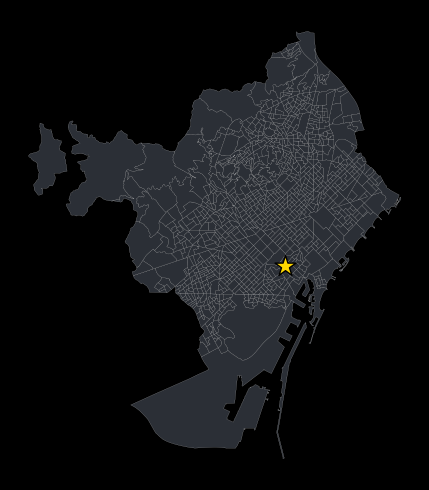

In [13]:
import matplotlib.pyplot as plt
from pyproj import Transformer

fig, ax = plt.subplots(figsize=(5, 5), facecolor="black")

# Plot geometry
gdf_geom_soc.plot(
    ax=ax,
    color="#2b2f36",
    edgecolor="white",
    linewidth=0.1
)

# Remove axes
ax.set_axis_off()

# Add star at central Barcelona (Plaça de Catalunya)
lon, lat = 2.1734, 41.3851
transformer = Transformer.from_crs("EPSG:4326", gdf_geom_soc.crs, always_xy=True)
x, y = transformer.transform(lon, lat)

ax.scatter(
    x, y,
    marker="*",
    s=250,
    color="gold",
    edgecolor="black",
    zorder=5
)

plt.tight_layout()
plt.show()


__Figure 1. Map of Barcelona at the census-section level.__ The star indicates the location of Plaça de Catalunya, representing the city centre.

### 2.4 AirBnb Listings 

Airbnb listing data are used as a proxy for tourism-related activity in Barcelona, providing information on the location, price, and type of short-term rental accommodation across the city.

In [14]:
url = "https://data.insideairbnb.com/spain/catalonia/barcelona/2025-09-14/data/listings.csv.gz"

df_airbnb = pd.read_csv(url, compression="gzip", low_memory=False)

df_airbnb = df_airbnb[['price', 'latitude', 'longitude', 'id', 'room_type']]

df_airbnb['price'] = (
    df_airbnb['price']
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)

df_airbnb['geometry'] = df_airbnb.apply(
    lambda row: Point(row['longitude'], row['latitude']),
    axis=1
)

gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry='geometry', crs='epsg:4326')

## 3 Exploratory Data Analysis

### 3.1 Disposable Income and Income Inequality

In this section, we explore the spatial patterns of socio-economic variables to provide context for the city of Barcelona. Disposable income per capita and the Gini index are used to capture differences in income levels and income inequality across census sections. Together, these indicators provide an overview of socio-economic disparities in the city.

Global Moran’s $I$ is used to assess the degree of spatial autocorrelation for each variable, using a Queen contiguity weight matrix to define spatial relationships between census sections, allowing us to test whether similar feature values tend to cluster spatially or are randomly distributed across the city.

In [15]:
gdf_moran = gdf_geom_soc.to_crs(epsg=25831)

w = lps.weights.Queen.from_dataframe(gdf_moran, use_index=False)
w.transform = "r"

y_income = gdf_moran["Import_Euros"].values
moran_income = Moran(y_income, w)

print("Income Moran's I:", round(moran_income.I, 3))
print("p-value:", round(moran_income.p_sim, 4))

y_gini = gdf_moran["Index_Gini"].values
moran_gini = Moran(y_gini, w)

print("Gini Index Moran's I:", round(moran_gini.I, 3))
print("p-value:", round(moran_gini.p_sim, 4))

Income Moran's I: 0.847
p-value: 0.001
Gini Index Moran's I: 0.737
p-value: 0.001


In [16]:
fig = px.choropleth_map(
    gdf_geom_soc,
    geojson=gdf_geom_soc.geometry.__geo_interface__,
    locations=gdf_geom_soc.index,
    color="Import_Euros",
    color_continuous_scale="Plasma",
    hover_name="nom_barri",
    hover_data={
        "nom_districte": True,
        "Import_Euros": ":,.0f",
        "Index_Gini": True
    },
    map_style="carto-darkmatter",
    zoom=10,
    center={"lat": 41.38, "lon": 2.15},
    opacity=0.75,
    title="Disposable Income per Capita by Census Section, Barcelona (2022)"
)

fig.add_trace(
    go.Scattermap(
        lon=[2.1734],
        lat=[41.3851],
        mode="markers+text",
        text=["Plaça de Catalunya"],
        marker=dict(
            size=20,
            color="white",
            opacity=0.9
        ),
        name="City centre"
    )
)

fig.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    template="plotly_dark"
)

fig.show();


__Figure 2. Disposable Income per Capita by Census Section (2022).__ Lower income values are concentrated in areas surrounding the city centre, while higher income census sections are predominantly located in the western and north-western parts of the city. Global Moran’s $I$ indicates strong and statistically significant positive spatial autocorrelation $(I = 0.847$, $p = 0.001)$. This shows that census sections with similar income levels tend to be located near one another rather than being randomly distributed.

In [17]:
fig = px.choropleth_map(
    gdf_geom_soc,
    geojson=gdf_geom_soc.geometry.__geo_interface__,
    locations=gdf_geom_soc.index,
    color="Index_Gini",
    color_continuous_scale="Plasma",  
    hover_name="nom_barri",
    hover_data={
        "nom_districte": True,
        "Index_Gini": True,
        "Import_Euros": ":,.0f"
    },
    map_style="carto-darkmatter",
    zoom=10,
    center={"lat": 41.38, "lon": 2.15},
    opacity=0.75,
    title="Income Inequality (Gini Index) by Census Section, Barcelona (2022)"
)

fig.add_trace(
    go.Scattermap(
        lon=[2.1734],
        lat=[41.3851],
        mode="markers+text",
        text=["Plaça de Catalunya"],
        marker=dict(
            size=20,
            color="white",
            opacity=0.9
        ),
        name="City centre"
    )
)

fig.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    template="plotly_dark"
)

fig.show();

__Figure 3. Income Inequality (Gini Index) by Census Section (2022).__ Higher levels of income inequality are predominantly observed in central census sections of the city. In addition, elevated Gini values are also present in parts of the north-western area, which are characterized by high disposable income, highlighting the coexistence of socio-economic contrasts within affluent neighborhoods. This pattern is strongly clustered rather than random, as confirmed by a high and statistically significant Global Moran’s $I$ $(I = 0.737, p = 0.001)$.

In [18]:
y_gini = gdf_moran["Index_Gini"].values

moran_gini = Moran(y_gini, w)

print("Gini Index Moran's I:", round(moran_gini.I, 3))
print("p-value:", round(moran_gini.p_sim, 4))

Gini Index Moran's I: 0.737
p-value: 0.001


Overall, income and income inequality in Barcelona display strong spatial clustering, with areas close to city center characterized by both lower income levels and higher income inequality. These socio-economic patterns provide important context for understanding how tourism pressure may disproportionately affect already vulnerable neighbourhoods, particularly in areas closer to the city center with high tourism activity.

### 3.2 AirBnb Listings, Walking Isochrones, and Regionalisation

In this section, we examine tourism pressure in Barcelona using the spatial distribution and pricing of Airbnb listings, analysed across walking accessibility zones and spatially coherent regions derived through regionalisation.

In [19]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="black")

# Plot geometry
gdf_geom_soc.plot(
    ax=ax,
    color="#2b2f36",
    edgecolor="white",
    linewidth=0.1
)

gdf_airbnb.plot(
    ax=ax,
    column='room_type',
    legend=True,
    markersize=1,
    alpha=0.7
)


ax.set_axis_off()
plt.show();


__Figure 4. Spatial distribution of Airbnb listings in Barcelona by room type.__ Entire-home and private-room listings are densely concentrated in specific neighbourhoods, reflecting uneven tourism pressure across the city.

__Table 1. Distribution and average price of Airbnb listings by room type in Barcelona.__ Entire-home listings constitute the largest share of listings and exhibit the highest average prices, while private and shared rooms are generally offered at lower prices. This distribution suggests that tourism-related accommodation is primarily oriented toward entire houses/apartments, which may intensify pressures on the local housing market.

In [20]:
(gdf_airbnb
    .groupby('room_type')
    .agg(
        Listing_Count=('price','size'),
        Average_Price=('price','mean')
        )
)

Listing_Count  Average_Price
room_type                                    
Entire home/apt          11789     231.734311
Hotel room                  94     223.940000
Private room              7417      88.081438
Shared room                110      93.314815

Walking isochrones are generated from the city centre to define meaningful accessibility zones based on pedestrian travel time. These zones provide a consistent spatial categories for comparing variables in this study, including the spatial distribution of Airbnb listings and price. By using travel-time–based areas rather than administrative boundaries or straight-line distances, the analysis captures how tourism pressure vary with proximity to the city centre.

In [21]:
# Configure network type, trip times, and travel speed
# Define city center of Barcelona (Plaça de Catalunya)
lon, lat = 2.1734, 41.3851
trip_times = [5, 15, 30, 45, 60]  # Duration of walk
travel_speed = 4 #km/h
network_type = 'walk'

# Big enough radius to cover 30-min walk
G = ox.graph_from_point((lat, lon), dist=4000, network_type="walk")

# Project network using ESPG: 4326 
G = ox.project_graph(G, to_crs='epsg:4326')

# Add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

# Assign one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)

In [22]:
# Create a list of isochrones given a lon lat
center_node = ox.distance.nearest_nodes(G, lon, lat)

# Create isochrone polygons from city center
shp_iso = make_isochrone_polys(G, center_node, trip_times, buffer=0.0003)

# Transform to a geodataframe
iso_gdf = gpd.GeoDataFrame(
    {"time": trip_times[::-1]},
    geometry=shp_iso,
    crs="EPSG:4326"
)

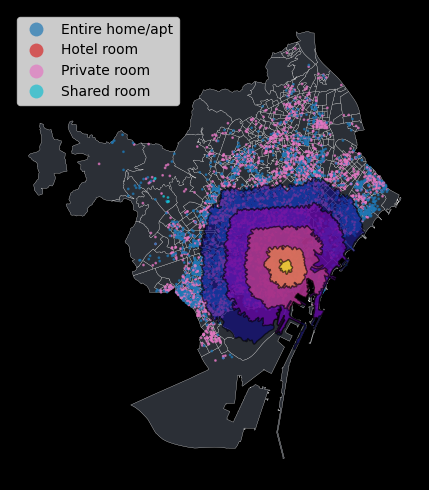

In [23]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor="black")

# Census sections
gdf_geom_soc.to_crs(epsg=4326).plot(
    ax=ax,
    color="#2b2f36",
    edgecolor="white",
    linewidth=0.2
)

# Airbnb listings
gdf_airbnb.plot(
    ax=ax,
    column='room_type',
    legend=True,
    markersize=1,
    alpha=0.7
)

# Isochrones
iso_gdf.plot(
    ax=ax,
    color=iso_colors,
    alpha=0.6,
    edgecolor="black",
    linewidth=1
)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()


__Figure 5. Walking isochrones (5–60 minutes) from Plaça de Catalunya.__ The isochrone map illustrates pedestrian accessibility from Plaça de Catalunya across progressively increasing walking-time intervals of 5, 15, 30, 45, and 60 minutes.

In [24]:
# Create a geodataframe
iso_gdf = gpd.GeoDataFrame(
    {"time": [str(trip_time) for trip_time in trip_times[::-1]]},
    geometry=shp_iso,
    crs="EPSG:4326"
)

__Table 2. Distribution and average price of Airbnb listings by room type across walking-time isochrones from the city centre.__ Entire-home listings dominate across all accessibility zones and are most expensive within shorter walking-time isochrones (e.g. 5-minute walk from the city centre), indicating higher-priced tourist accommodation in areas of greatest accessibility.

In [25]:
# Assign isochrone time to each Airbnb listing
airbnb_iso = gpd.sjoin(
    gdf_airbnb,
    iso_gdf[['time', 'geometry']],
    how='left',
    predicate='within'
)

airbnb_iso['time'] = airbnb_iso['time'].fillna('>60')

# Define time ordering
order = ["5","15","30","45","60",">60"]

airbnb_iso['time'] = pd.Categorical(
    airbnb_iso['time'],
    categories=order,
    ordered=True
)

# Group by time × room_type
airbnb_stats = (
    airbnb_iso
    .groupby(['time', 'room_type'], observed=True)  
    .agg(
        Listing_Count=('id', 'size'),
        Average_Price=('price', 'mean')
       
    )
    .sort_index()                                   
)

airbnb_stats


Listing_Count  Average_Price
time room_type                                    
5    Entire home/apt            144     201.138462
     Private room               136      88.372093
15   Entire home/apt           2154     221.661231
     Hotel room                  22     237.470588
     Private room              1556     110.245059
     Shared room                  7     197.857143
30   Entire home/apt           5734     230.777271
     Hotel room                  65     237.517241
     Private room              3517      99.966282
     Shared room                 57     110.052632
45   Entire home/apt           8514     234.956146
     Hotel room                  86     229.511628
     Private room              5034      94.432888
     Shared room                 84     110.048193
60   Entire home/apt          10525     229.656460
     Hotel room                  94     223.940000
     Private room              6187      91.668831
     Shared room                100      99.397959
>60  Entire home/apt           1264     249.000000
     Private room              1230      70.074316
     Shared room                 10      33.700000

Regionalisation is used to group neighbouring census areas into spatially coherent regions based on similarities in AirBnb listings and socio-economic conditions. This approach allows us to identify broader spatial patterns to relate tourism pressure across the city of Barcelona.

In [26]:
# Assign listings to census area
df_airbnb = gpd.sjoin(
    gdf_airbnb,          
    gdf_geom_soc,        
    how="left",
    predicate="within"
)

# Count and Price
df_airbnb_stats = (df_airbnb
     .groupby(["codi_districte", "codi_barri", "codi_seccio_censal"])
    .agg(
        Listing_Count=('price','size'),
        Average_Price=('price','mean')
        )
)

# Join to main dataframe
gdf_geom_soc_with_airbnb = gdf_geom_soc.merge(
    df_airbnb_stats,
    on=["codi_districte", "codi_barri", "codi_seccio_censal"],
    how="left"
)

In [27]:
# Normalize features using percentile rank
features = ["Listing_Count", "Average_Price", "Import_Euros", "Index_Gini"]

for feature in features:
    gdf_geom_soc_with_airbnb[f"{feature}_pct"] = (
        gdf_geom_soc_with_airbnb[feature].rank(pct=True)
    )

In [28]:
# Regionalisation
features_norm = ["Listing_Count_pct", "Average_Price_pct", "Import_Euros_pct", "Index_Gini_pct"]

gdf_reg = gdf_geom_soc_with_airbnb.dropna(subset=features_norm).copy()

In [29]:
queen = lps.weights.Queen.from_dataframe(gdf_reg, use_index=False)
queen.transform = "r"

agg = AgglomerativeClustering(
    n_clusters=5,          
    connectivity=queen.sparse
)

('WARNING: ', 653, ' is an island (no neighbors)')
('WARNING: ', 713, ' is an island (no neighbors)')
('WARNING: ', 745, ' is an island (no neighbors)')
('WARNING: ', 761, ' is an island (no neighbors)')


In [30]:
gdf_reg["region"] = agg.fit_predict(gdf_reg[features_norm])

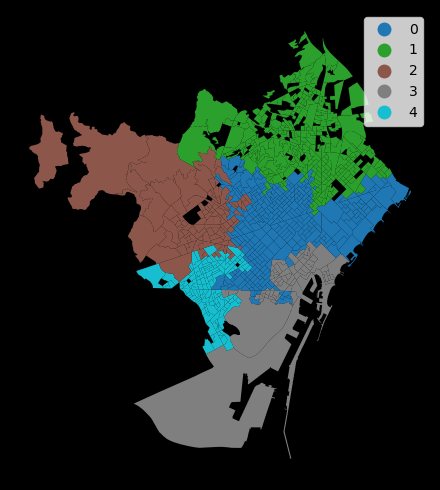

In [31]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="black")

gdf_reg.plot(column="region",
             categorical=True,
             legend=True,
             ax=ax,
             linewidth=0.2)

# Remove axes
ax.set_axis_off()

plt.tight_layout()
plt.show()

__Figure 6. Spatial regionalisation of Barcelona based on Airbnb listing density, average prices, and socio-economic data.__ The map shows five spatially contiguous regions identified through agglomerative clustering, highlighting distinct patterns of tourism pressure across the city.

__Table 3. Summary statistics by region.__ The regionalisation reveals clear differences between region. **Regions $0$ and $3$** combine relatively higher numbers of Airbnb listings with higher average prices and may therefore experience the impacts of tourism pressure more strongly. In contrast, **Region $2$** is distinguished by high income levels and elevated income inequality alongside moderate Airbnb presence and prices, which suggests that tourism-related activity in this region is less intense. This spatial differentiation highlights the uneven distribution of tourism pressure across Barcelona.

In [33]:
(gdf_reg
    .groupby("region")[["Listing_Count", "Average_Price", "Import_Euros", "Index_Gini"]]
    .mean()
    .round(2)
)

Listing_Count  Average_Price  Import_Euros  Index_Gini
region                                                        
0               32.71         206.58      25214.49       33.21
1                4.67         104.93      19600.03       29.28
2                9.82         144.94      34887.34       38.43
3               68.01         132.44      17151.29       34.68
4                9.93         150.23      23448.56       30.81